## Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import scipy as sc
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import sklearn
import glob
import pathlib as pl

In [2]:
hr_eigs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/eigvecs_hrdps_annual.csv', header = None) )
hr_PCs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/PCs_hrdps_annual.csv', header = None) )
hr_data = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/raw_data_3h.csv', header = None) )
print(hr_PCs.shape)
print(hr_eigs.shape)

(136192, 50)
(50, 2904)


In [3]:
psl_eigs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/eigvecs_psl.csv', header = None) )
psl_PCs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/PCs_psl.csv', header = None) )
psl_data = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/raw_data_psl.csv', header = None) )
print(psl_PCs.shape)
print(psl_eigs.shape)

(625, 50)
(50, 2904)


In [4]:
cw_eigs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/eigvecs_winds.csv', header = None) )
cw_PCs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/PCs_winds.csv', header = None) )
cw_data = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/raw_data_winds.csv', header = None) )
print(cw_PCs.shape)
print(cw_eigs.shape)

(1250, 30)
(30, 2904)


In [24]:
##data must be converted into a 2D matrix for pca analysis
##transform takes a 3D data array (time, a, b) -> (a*b, time)
##(the data grid is flattened a column using numpy.flatten)

def transform(xarr):
    arr = np.array(xarr) ##converting to numpy array
    arr = arr.reshape(arr.shape[0], arr.shape[1]*arr.shape[2]) ##reshaping from size (a, b, c) to (a, b*c)
    arr = arr.transpose()
    return arr

def reverse(mat, orig_shape):
    arr = np.copy(mat)
    arr = arr.transpose()
    arr = arr.reshape(orig_shape[0], orig_shape[1], orig_shape[2]) ##reshaping back to original array shape
    return arr

In [6]:
def fit_modes(vectors, num_vec, data, result_size):  
    result = np.empty((result_size, vectors.shape[1]))
    scores = np.empty(result_size)
    for i in range(result_size):
        vec = vectors[0:num_vec,:].T
        reg = LinearRegression().fit(vec, data[i,:])
        result[i] = reg.predict(vec)
        scores[i] = reg.score(vec, data[i,:])
    return (result, scores)

In [7]:
def get_scores(num_scores, eigvecs, arr, row):  
    scores = np.empty(num_scores)
    for i in range(num_scores):
        vec = eigvecs[0 : i+1 , :].T
        reg = LinearRegression().fit(vec, arr[row,:])
        scores[i] = reg.score(vec, arr[row,:])
    return scores

In [8]:
comb_eigs = np.empty((50, 2904))
for i in range(25):
    comb_eigs[2*i] = cw_eigs[i]
    comb_eigs[2*i + 1] = psl_eigs[i]

In [9]:
print(get_scores(20, cw_eigs, hr_eigs, i))

[0.00096025 0.00398921 0.00477349 0.01032967 0.01083522 0.01300766
 0.01535073 0.01543602 0.01549445 0.01815119 0.01907941 0.02260963
 0.0243193  0.03022098 0.03111242 0.03271776 0.0356853  0.03666859
 0.03928215 0.04087647]


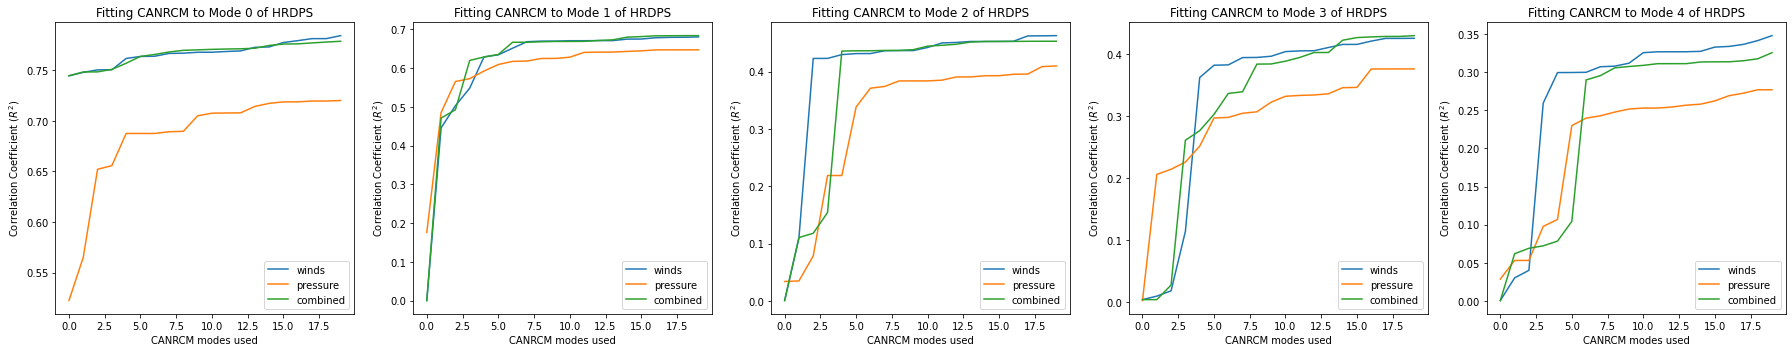

In [10]:
n = 5
fig, ax = plt.subplots(1, n, figsize=(5*n, 5))

for i in range(n):
    ax[i].plot(get_scores(20, cw_eigs, hr_eigs, i), label = "winds")
    ax[i].plot(get_scores(20, psl_eigs, hr_eigs, i), label = "pressure")
    ax[i].plot(get_scores(20, comb_eigs, hr_eigs, i), label = "combined")
    ax[i].set_title("Fitting CANRCM to Mode {} of HRDPS".format(i))
    ax[i].set_xlabel("CANRCM modes used")
    ax[i].set_ylabel("Correlation Coefficient ($R^2$)")
    ax[i].legend()
    
plt.tight_layout()

1.4180081889821725
1.3081038721811002
2.2521874732497116
2.8417251090489195
3.8741308102876957


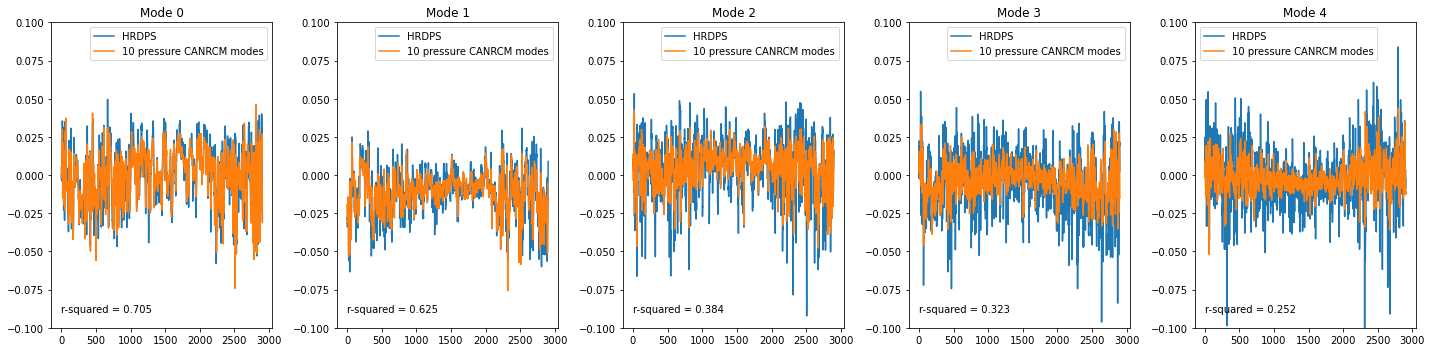

In [11]:
new_eigs, scores = fit_modes(psl_eigs, 10, hr_eigs, 5)

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    
    ax[i].plot(hr_eigs[i], label = "HRDPS")
    ax[i].plot(new_eigs[i], label = "10 pressure CANRCM modes")
    ax[i].set_ylim(-0.1, 0.1)
    ax[i].annotate("r-squared = {:.3f}".format(scores[i]), (0, -0.09))
    ax[i].set_title("Mode {}".format(i))
    print(np.mean(hr_eigs[i]**2) / np.mean(new_eigs[i]**2))
    ax[i].legend()
plt.tight_layout()

1.1411256295704912
1.1232248447325148
1.426022930053855
1.537746420160929
1.7743084152854953


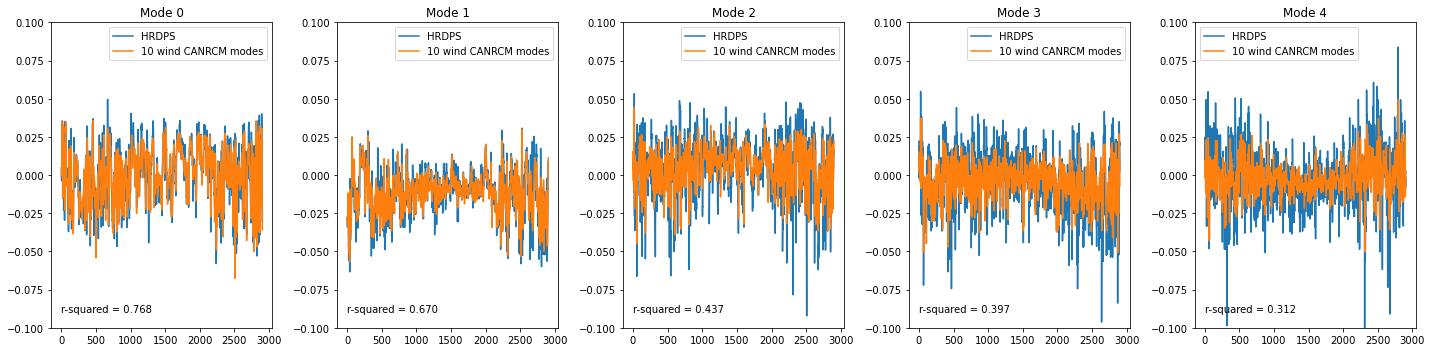

In [12]:
new_eigs, scores = fit_modes(cw_eigs, 10, hr_eigs, 5)

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    
    ax[i].plot(hr_eigs[i], label = "HRDPS")
    ax[i].plot(new_eigs[i], label = "10 wind CANRCM modes")
    ax[i].set_ylim(-0.1, 0.1)
    ax[i].annotate("r-squared = {:.3f}".format(scores[i]), (0, -0.09))
    ax[i].set_title("Mode {}".format(i))
    ax[i].legend()
    print(np.sqrt( np.mean(hr_eigs[i]**2) / np.mean(new_eigs[i]**2) ) )
plt.tight_layout()

## Conserving Energy

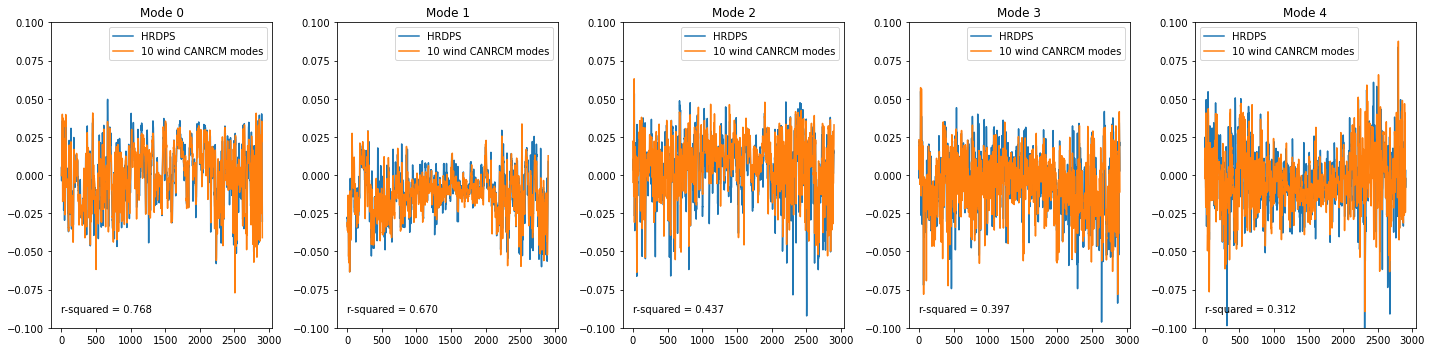

In [13]:
new_eigs, scores = fit_modes(cw_eigs, 10, hr_eigs, 5)

fig, ax = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    f = np.sqrt( np.mean(hr_eigs[i]**2) / np.mean(new_eigs[i]**2) )
    ax[i].plot(hr_eigs[i], label = "HRDPS")
    ax[i].plot(new_eigs[i]*f, label = "10 wind CANRCM modes")
    ax[i].set_ylim(-0.1, 0.1)
    ax[i].annotate("r-squared = {:.3f}".format(scores[i]), (0, -0.09))
    ax[i].set_title("Mode {}".format(i))
    ax[i].legend()
    
plt.tight_layout()

In [14]:
def equalize_energy(eigs, old_eigs):
    ##for i in range(int( eigs.shape[0] )):
    ##    print(i)
    ##    f = np.sqrt( np.mean(old_eigs[i]**2) / np.mean(eigs[i]**2) )
    ##    new_eigs[i] = eigs[i]*f
    new_eigs = np.sqrt( (old_eigs[0:eigs.shape[0]]**2).mean(axis = 1)/(eigs**2).mean(axis = 1))* eigs.T
    return new_eigs.T

In [15]:
new_eigs.shape

(5, 2904)

## Comparing data

In [16]:
new_eigs.shape

(5, 2904)

In [17]:
split = int( hr_data.shape[0]/2 )
u_data = reverse(hr_data[:split,:], (0, 266, 256)) ##getting HRDPS u-winds
v_data = reverse(hr_data[split:,:], (0, 266, 256)) ##getting HRDPS v-winds

In [18]:
new_eigs = fit_modes(cw_eigs, 10, hr_eigs, 30)[0]
new_eigs = equalize_energy(new_eigs, hr_eigs)

In [19]:
recon = np.matmul(hr_PCs[:,0:30], new_eigs)
split4 = int( recon.shape[0]/2 )
u_data_rec = reverse(recon[:split4,:], (0, 266, 256)) ##reconstructing u_winds from n PCs
v_data_rec = reverse(recon[split4:,:], (0, 266, 256)) ##reconstructing v_winds from n PCs

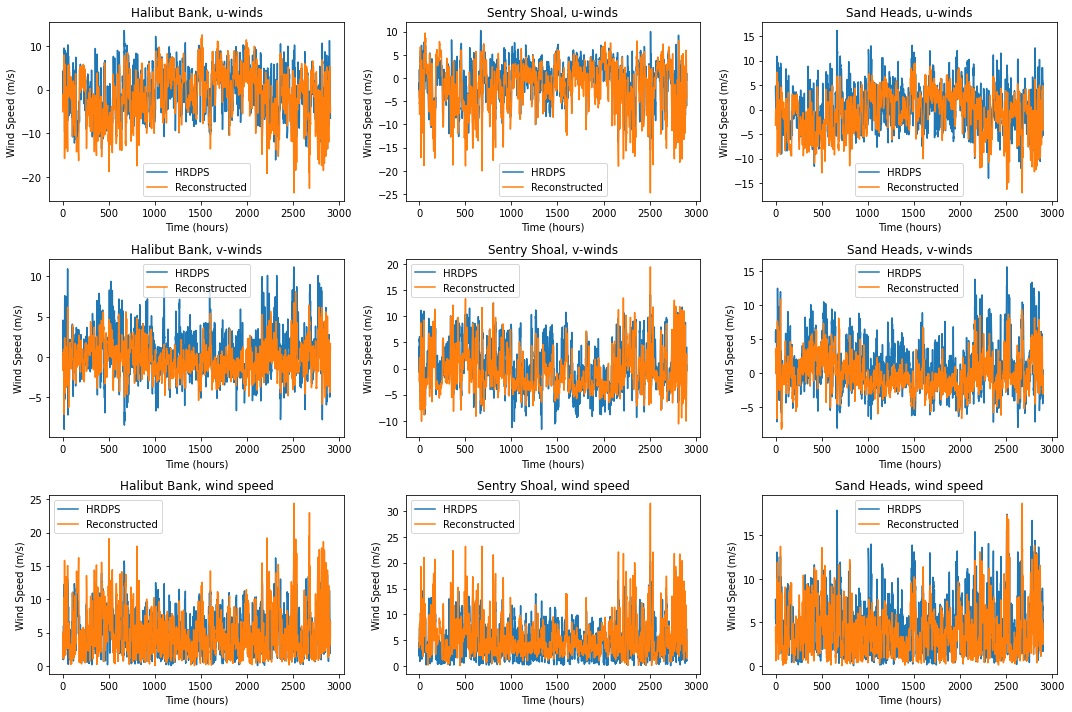

In [20]:
## Plotting raw / averaged data at three locations.

fig, ax = plt.subplots(3, 3, figsize=(15, 10))

ax[0, 0].plot(u_data[:,142,139], label = "HRDPS")
ax[0, 0].plot(u_data_rec[:,142,139], label = "Reconstructed")
ax[0, 0].set_title("Halibut Bank, u-winds")
ax[0, 0].set_xlabel("Time (hours)")
ax[0, 0].set_ylabel("Wind Speed (m/s)")
ax[0, 0].legend()

ax[0, 1].plot(u_data[:,174,107], label = "HRDPS")
ax[0, 1].plot(u_data_rec[:,174,107], label = "Reconstructed")
ax[0, 1].set_title("Sentry Shoal, u-winds")
ax[0, 1].set_xlabel("Time (hours)")
ax[0, 1].set_ylabel("Wind Speed (m/s)")
ax[0, 1].legend()

ax[0, 2].plot(u_data[:,129,149], label = "HRDPS")
ax[0, 2].plot(u_data_rec[:,129, 149], label = "Reconstructed")
ax[0, 2].set_title("Sand Heads, u-winds")
ax[0, 2].set_xlabel("Time (hours)")
ax[0, 2].set_ylabel("Wind Speed (m/s)")
ax[0, 2].legend()

ax[1, 0].plot(v_data[:,142,139], label = "HRDPS")
ax[1, 0].plot(v_data_rec[:,142,139], label = "Reconstructed")
ax[1, 0].set_title("Halibut Bank, v-winds")
ax[1, 0].set_xlabel("Time (hours)")
ax[1, 0].set_ylabel("Wind Speed (m/s)")
ax[1, 0].legend()

ax[1, 1].plot(v_data[:,174,107], label = "HRDPS")
ax[1, 1].plot(v_data_rec[:,174,107], label = "Reconstructed")
ax[1, 1].set_title("Sentry Shoal, v-winds")
ax[1, 1].set_xlabel("Time (hours)")
ax[1, 1].set_ylabel("Wind Speed (m/s)")
ax[1, 1].legend()

ax[1, 2].plot(v_data[:,129,149], label = "HRDPS")
ax[1, 2].plot(v_data_rec[:,129, 149], label = "Reconstructed")
ax[1, 2].set_title("Sand Heads, v-winds")
ax[1, 2].set_xlabel("Time (hours)")
ax[1, 2].set_ylabel("Wind Speed (m/s)")
ax[1, 2].legend()

ax[2,0].plot(np.sqrt(u_data[:,142,139]**2 + v_data[:,142,139]**2), label = "HRDPS")
ax[2,0].plot(np.sqrt(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2), label = "Reconstructed")
ax[2,0].set_xlabel("Time (hours)")
ax[2,0].set_title("Halibut Bank, wind speed")
ax[2,0].set_ylabel("Wind Speed (m/s)")
ax[2,0].legend()

ax[2,1].plot(np.sqrt(u_data[:,174,107]**2 + v_data[:,174,107]**2), label = "HRDPS")
ax[2,1].plot(np.sqrt(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2), label = "Reconstructed")
ax[2,1].set_xlabel("Time (hours)")
ax[2,1].set_title("Sentry Shoal, wind speed")
ax[2,1].set_ylabel("Wind Speed (m/s)")
ax[2,1].legend()

ax[2,2].plot(np.sqrt(u_data[:,129,149]**2 + v_data[:,129,149]**2) , label = "HRDPS")
ax[2,2].plot(np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2) , label = "Reconstructed")
ax[2,2].set_xlabel("Time (hours)")
ax[2,2].set_title("Sand Heads, wind speed")
ax[2,2].set_ylabel("Wind Speed (m/s)")
ax[2,2].legend()

plt.tight_layout()

In [21]:
nums = np.arange(0, 37, 3)
print(nums)

[ 0  3  6  9 12 15 18 21 24 27 30 33 36]


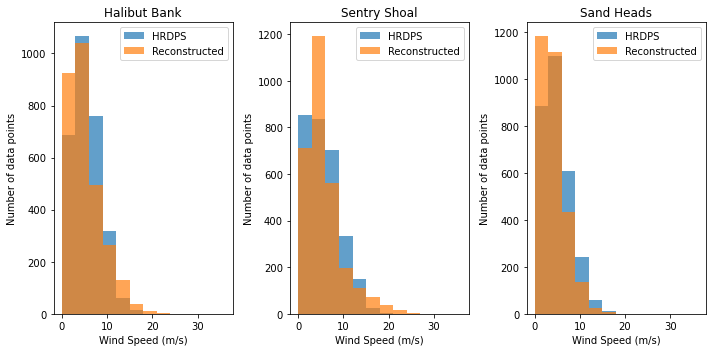

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].set_title("Halibut Bank")
ax[0].hist(np.sqrt(u_data[:,142,139]**2 + v_data[:,142,139]**2), bins = nums, label = "HRDPS", alpha = 0.7)
ax[0].hist(np.sqrt(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2), bins = nums, label = "Reconstructed", alpha = 0.7)
ax[0].set_xlabel("Wind Speed (m/s)")
ax[0].set_ylabel("Number of data points")
ax[0].legend()

ax[1].set_title("Sentry Shoal")
ax[1].hist(np.sqrt(u_data[:,174,107]**2 + v_data[:,174,107]**2), bins = nums, label = "HRDPS", alpha = 0.7)
ax[1].hist(np.sqrt(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2), bins = nums, label = "Reconstructed", alpha = 0.7)
ax[1].set_xlabel("Wind Speed (m/s)")
ax[1].set_ylabel("Number of data points")
ax[1].legend()

ax[2].set_title("Sand Heads")
ax[2].hist(np.sqrt(u_data[:,129,149]**2 + v_data[:,129,149]**2) , bins = nums,  label = "HRDPS", alpha = 0.7)
ax[2].hist(np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2) , bins = nums, label = "Reconstructed", alpha = 0.7)
ax[2].set_xlabel("Wind Speed (m/s)")
ax[2].set_ylabel("Number of data points")
ax[2].legend()

plt.tight_layout()

In [23]:
##MAE (duplicate notebook)
##test different #'s of modes